# Model with conditional interaction

In this example, we show the heterogeneity of the global effects, using PDP, ALE, and RHALE, on a model with conditional interactions .
In particular, we:

1. show how to use `effector` to compute and visualie the heterogeneity of the global effects using PDP, ALE, and RHALE
2. find the heterogeneity of the global effects using analytical derivations
3. test that (1) and (2) match

We will use the following model:

$$ 
f(x_1, x_2, x_3) = x_1 x_2^2 + e^{x_3} 
$$

where the features $x_1, x_2$, and $x_3$ are independent and uniformly distributed in the interval $[-1, 1]$.

The model has an interaction between $x_1$ and $x_2$ through the term:

$$
f_{1,2}(x_1, x_2) = x_1 x_2^2.
$$

This interaction implies that the effect of $x_1$ on the output $y$ depends on the value of $x_2^2$, and vice versa. This dependency introduces heterogeneity, as the contribution of $x_1$ to the output changes with the value of $x_2$.

Each global effect method has a different formula for qunatifying such heterogeneity; below, we will see how PDP, ALE, and RHALE handles it.


In contrast, the term:

$$
f_3(x_3) = e^{x_3}
$$

does not involve any interaction with $x_1$ or $x_2$. As a result, $x_3$ has a global effect with zero heterogeneity, meaning its contribution to the output is consistent regardless of the values of other features.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import effector

np.random.seed(21)

model = effector.models.GeneralInteraction()
dataset = effector.datasets.IndependentUniform(dim=3, low=-1, high=1)
x = dataset.generate_data(10000)

## PDP

### Effector

Let's see below the PDP heterogeneity for each feature, using `effector`.

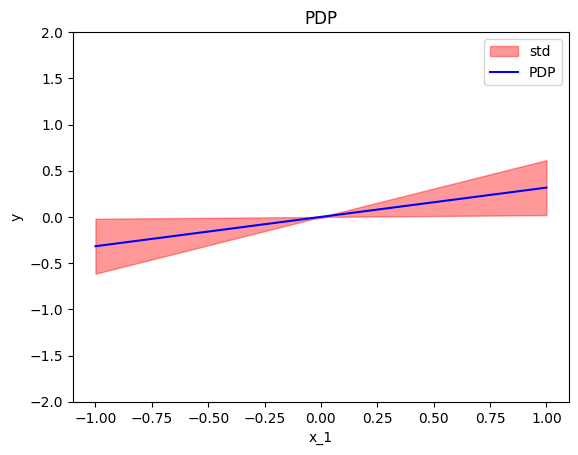

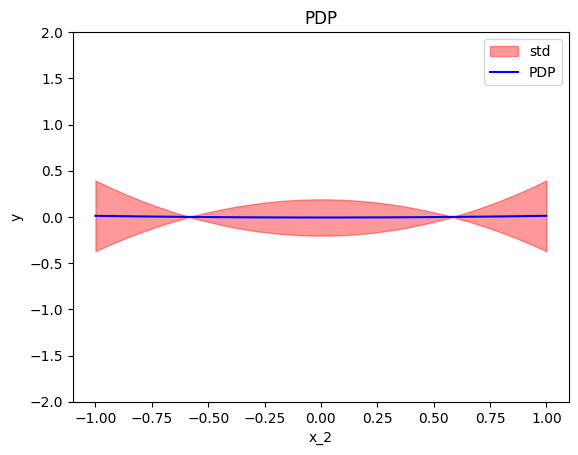

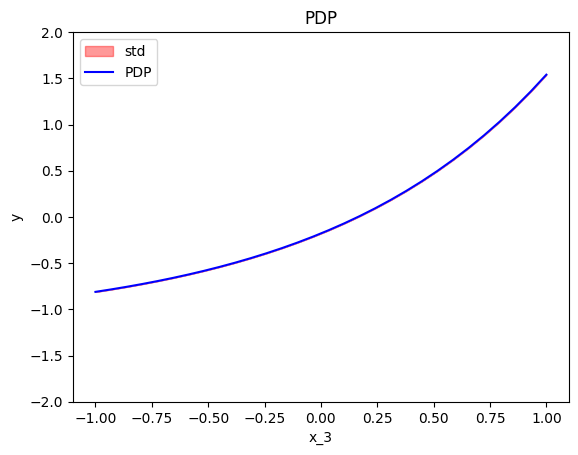

In [2]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits)
pdp.fit(features="all", centering=True)
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, heterogeneity=True, y_limits=[-2, 2])

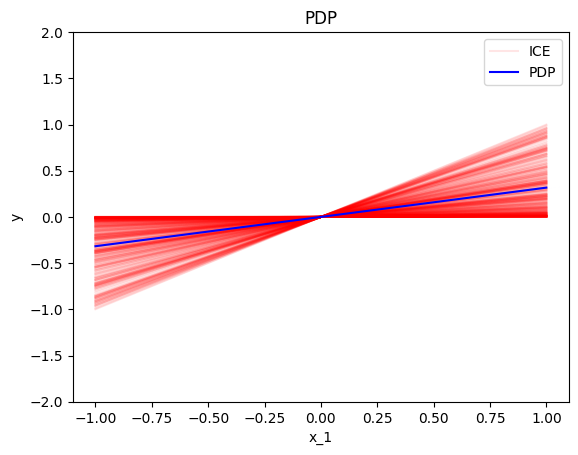

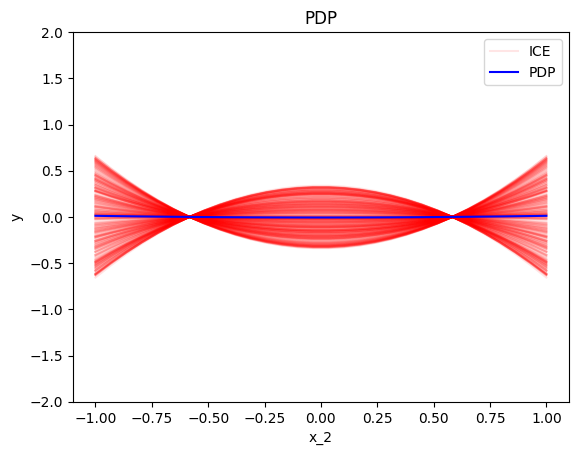

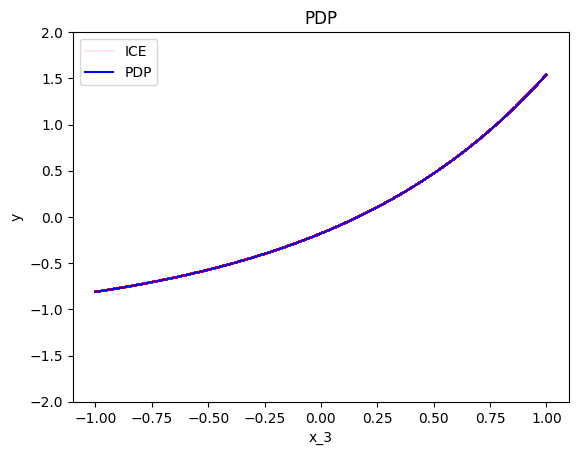

In [3]:
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, heterogeneity="ice", y_limits=[-2, 2])

PDP states that:

* $x_1$ has a positive heteogeneity along all values of $x_1$, i.e., $h(x_1) > 0$ for all $x_1$. The mean heterogeneity $H_{x_1} \approx 0.3$. ICE plots indicate that local effects form two opposing groups: $-x_1^2 + c_2$ for $x_2 < 0$ and $x_1^2 + c_1$ for $x_2 \geq 0$.
* $x_2$ has a positive heteogeneity along all values of $x_2$, i.e., $h(x_2) > 0$ for all $x_2$. The mean heterogeneity $H_{x_2} \approx 0.3$. ICE plots show a smooth range of varying effects around the global trend, without distinct groups.
* $x_3$ has an effect of $e^{x_3}$

In [4]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits, nof_instances="all")
pdp.fit(features="all", centering=True)
heter_per_feat = []
for feature in [0, 1, 2]:
    y_mean, y_var = pdp.eval(feature=feature, xs=np.linspace(-1, 1, 100), centering=True, heterogeneity=True)
    print(f"Heterogeneity of x_{feature}: {y_var.mean():.3f}")
    heter_per_feat.append(y_var.mean())

Heterogeneity of x_0: 0.030
Heterogeneity of x_1: 0.030
Heterogeneity of x_2: 0.000


### Derivations

How PDP leads to these heterogeneity functions? Are they meaningfull? Let's have some analytical derivations.
If you don't care about the derivations, skip the following three cells and go directly to the coclusions.

### For $x_1$

The average effect is:

$$
PDP(x_1) = \frac{1}{3} x_1 + c,
$$

The ICE plots are $x_{2,i}^2 x_1 + e^{x_3^i}$, and their centered versions are $x_1 x_{2,i}^2 - \frac{1}{3} x_1$, which becomes:

$$
\left( x_1 (x_{2,i}^2 - \frac{1}{3}) \right)^2.
$$

$$
h(x_1) = \frac{1}{N} \sum_i^N \left( ICE^i_c(x_1) - PDP_c(x_1) \right)^2
$$

$$
h(x_1) = \frac{1}{N} \sum_i^N \left( x_1^2 (x_{2,i}^2 - \frac{1}{3})^2 \right)
$$

$$
h(x_1) = x_1^2 \cdot \text{Var}(x_2^2).
$$

Since $x_2^2$ is distributed uniformly in $[0, 1]$, its variance is:

$$
\text{Var}(x_2^2) = \frac{1}{5} - \left(\frac{1}{3}\right)^2 = \frac{4}{45}.
$$

The heterogeneity is the average value:

$$
H_{x_1} = \frac{\int_{-1}^{1} x_1^2 \cdot \frac{4}{45} \, \partial x_1}{2}
$$

$$
H_{x_1} = \frac{4}{45} \cdot \mathbb{E}[x_1^2]
$$

$$
H_{x_1} = \frac{4}{45} \cdot \frac{1}{3}
$$

$$
H_{x_1} = \frac{4}{135} \approx 0.0296.
$$


### For $x_2$

The average effect is:

$$
PDP(x_2) = \mathbb{E}[x_1] x_2^2 + \mathbb{E}[e^{x_3}] = 0,
$$

The ICE plots are $x_1^i x_2^2 + e^{x_3^i}$, and their centered versions are:

$$
ICE^i_c(x_2) = x_1^i x_2^2.
$$

$$
h(x_2) = \frac{1}{N} \sum_i^N \left( ICE^i_c(x_2) - PDP_c(x_2) \right)^2
$$

$$
h(x_2) = \frac{1}{N} \sum_i^N \left( x_1^i x_2^2 \right)^2
$$

$$
h(x_2) = \mathbb{E}[x_1^2] \cdot \mathbb{E}[x_2^4].
$$

The expectations are:

$$
\mathbb{E}[x_1^2] = \frac{1}{3}, \quad \mathbb{E}[x_2^4] = \frac{1}{5}.
$$

The heterogeneity is:

$$
H_{x_2} = \frac{1}{3} \cdot \frac{1}{5}
$$

$$
H_{x_2} = \frac{1}{15} \approx 0.0667.
$$

### For $x_3$

There is no interaction involving $x_3$, as $e^{x_3}$ is independent of $x_1$ and $x_2$. The ICE plots are constant for each $x_3$, and thus their centered versions have no variability.

$$
h(x_3) = \frac{1}{N} \sum_i^N \left( ICE^i_c(x_3) - PDP_c(x_3) \right)^2
$$

$$
h(x_3) = 0.
$$

The heterogeneity is:

$$
H_{x_3} = 0.
$$

### Conclusions


In [5]:
def pdp_ground_truth(feature, xs):
    if feature == 0:  
        ff = lambda x: (4/45) * x**2  
        return ff(xs)
    elif feature == 1:  
        ff = lambda x: np.ones_like(x) * (1/15)  
        return ff(xs)
    elif feature == 2:  
        ff = lambda x: np.zeros_like(x)  
        return ff(xs)


In [6]:
# make a test
xx = np.linspace(-1, 1, 100)
for feature in [0, 1]:
    pdp_mean, pdp_heter = pdp.eval(feature=feature, xs=xx, centering=True, heterogeneity=True)
    y_heter = pdp_ground_truth(feature, xx)
    np.testing.assert_allclose(pdp_heter, y_heter, atol=1e-1)

## ALE

### Effector

Let's see below the PDP effects for each feature, using `effector`.

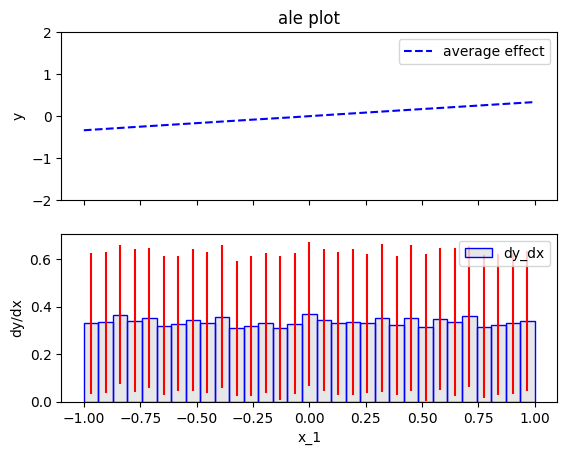

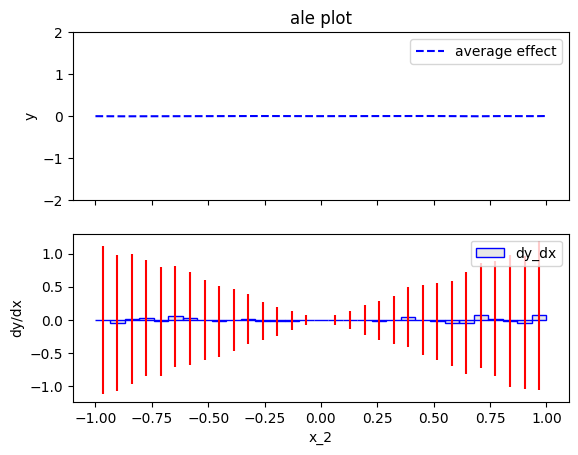

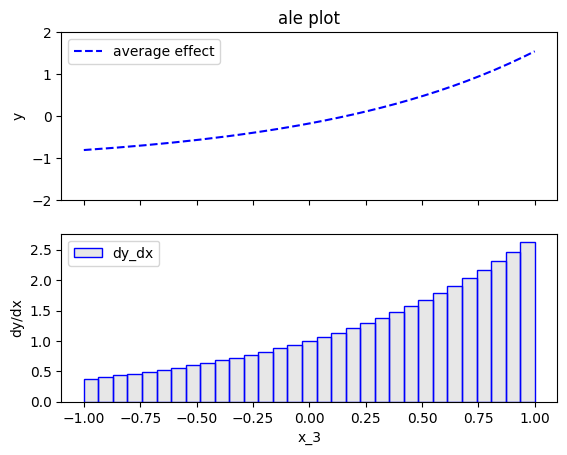

In [8]:
ale = effector.ALE(x, model.predict, axis_limits=dataset.axis_limits)
ale.fit(features="all", centering=True, binning_method=effector.binning_methods.Fixed(nof_bins=31))

for feature in [0, 1, 2]:
    ale.plot(feature=feature, centering=True, heterogeneity=True, y_limits=[-2, 2])

ALE states that:

- **Feature $x_1$**  
  The heterogeneity is strictly positive for all values of $x_1$. In fact, it remains constant across the entire range of $x_1$.  

- **Feature $x_2$**  
  The heterogeneity depends on where $x_2$ lies in $[-1,1]$. It equals $ \tfrac{4}{3} \, x_2^2 $, so:  
  - At $x_2 = 0$, the heterogeneity vanishes (0).  
  - As $\lvert x_2 \rvert$ grows toward 1, the heterogeneity increases, reaching its largest value of $\tfrac{4}{3}$ at $x_2 = \pm 1$.  

- **Feature $x_3$**  
  No heterogeneity is present for this feature.  


### Derivations

For $x_1$

The $x_1$-axis is divided into $K$ equal bins, indexed by $k = 1, \ldots, K$.  
We denote the center of the $k$-th bin by $c_k$, and the bin’s boundaries by $z_{k-1}, z_k$.  
For any data point $\mathbf{x}^i = (x_1^i, x_2^i, x_3^i)$ in the $k$-th bin of $x_1$, the local effect of $x_1$ is

$$
\frac{f(z_k, x_2^i, x_3^i) - f(z_{k-1}, x_2^i, x_3^i)}{z_k - z_{k-1}}
\;=\;
\frac{\bigl[z_k\,(x_2^i)^2 + e^{x_3^i}\bigr] \;-\; \bigl[z_{k-1}\,(x_2^i)^2 + e^{x_3^i}\bigr]}{z_k - z_{k-1}}
\;=\;
(x_2^i)^2.
$$

Hence, for each point in bin $k$, the local effect depends only on $(x_2^i)^2$.  
Since $x_2\sim \mathrm{Uniform}([-1,1])$, the variance of $(x_2^i)^2$ in that bin is:

$$
\mathrm{Var}\bigl((x_2^i)^2\bigr) 
\;=\; 
\frac{4}{45}.
$$

Therefore, for each bin $\mathcal{S}_k$,

$$
\begin{aligned}
h(x_1) 
&= \frac{1}{|\mathcal{S}_k|} \sum_{\mathbf{x}^i \in \mathcal{S}_k} 
    \left( 
      \frac{f(z_k, x_2^i, x_3^i) - f(z_{k-1}, x_2^i, x_3^i)}{z_k - z_{k-1}} 
      - \hat{\mu}_k^{ALE}  
    \right )^2 \\[6pt]
&\approx \mathrm{Var}\bigl((x_2^i)^2\bigr) 
\;=\; \frac{4}{45}.
\end{aligned}
$$


For $x_2$

The $x_2$-axis is divided into \(K\) equal bins, indexed by $k = 1, \ldots, K$.  
We denote the bin boundaries by $z_{k-1}, z_k$ and the midpoint by $c_k = \tfrac{z_{k-1}+z_k}{2}$.  
For a point $\mathbf{x}^i = (x_1^i, x_2^i, x_3^i)$ in the $k$-th bin of $x_2$, the local effect of $x_2$ is:

$$
\frac{f(x_1^i, z_k, x_3^i) - f(x_1^i, z_{k-1}, x_3^i)}{z_k - z_{k-1}}
\;=\;
\frac{x_1^i\,z_k^2 + e^{x_3^i} - \bigl(x_1^i\,z_{k-1}^2 + e^{x_3^i}\bigr)}{z_k - z_{k-1}}
\;=\;
x_1^i \,\frac{z_k^2 - z_{k-1}^2}{\,z_k - z_{k-1}\,}
\;=\;
x_1^i \,\bigl(z_k + z_{k-1}\bigr).
$$

Hence, inside bin $k$, the local effect is $x_1^i\,(z_k + z_{k-1})$.  
Because $\mathrm{E}[x_1^i] = 0$ and $\mathrm{E}[(x_1^i)^2]=\frac{1}{3}$, the variance of this local effect in bin $k$ is:

$$
\begin{aligned}
h(x_2) 
&= \frac{1}{|\mathcal{S}_k|}\sum_{\mathbf{x}^i \in \mathcal{S}_k}
\left(
  x_1^i \,(z_k + z_{k-1})
  - \hat{\mu}_k^{ALE}
\right)^2
\;\approx\;
(z_k + z_{k-1})^2 
\;\times\; 
\frac{1}{3}. \\[6pt]
&= \bigl(2\,c_k\bigr)^2 \;\frac{1}{3}
\;=\;
\frac{4}{3}\,c_k^2.
\end{aligned}
$$

**Result**:  
$$
h(x_2) \;=\;
\frac{4}{3}\,c_k^2
\quad
\text{for each bin center }c_k.
$$


For $x_3$:

The effect is zero everywehere.

In [11]:
def ale_ground_truth(feature):
    K = 31
    bin_centers = np.linspace(-1 + 1/K, 1 - 1/K, K)
    
    if feature == 0:
        return np.full_like(bin_centers, 4/45)
    elif feature == 1:
        return (4/3) * bin_centers**2
    elif feature == 2:
        return np.zeros_like(bin_centers)

In [12]:
# make a test
K = 31
bin_centers = np.linspace(-1 + 1/K, 1 - 1/K, K)
for feature in [0, 1, 2]:
    bin_var = ale.feature_effect[f"feature_{feature}"]["bin_variance"]
    gt_var = ale_ground_truth(feature)
    mask = ~np.isnan(gt_var)
    np.testing.assert_allclose(bin_var[mask], gt_var[mask], atol=1e-1)

### Conclusions

Are the ALE effects intuitive?

## RHALE

### Effector

Let's see below the RHALE effects for each feature, using `effector`.

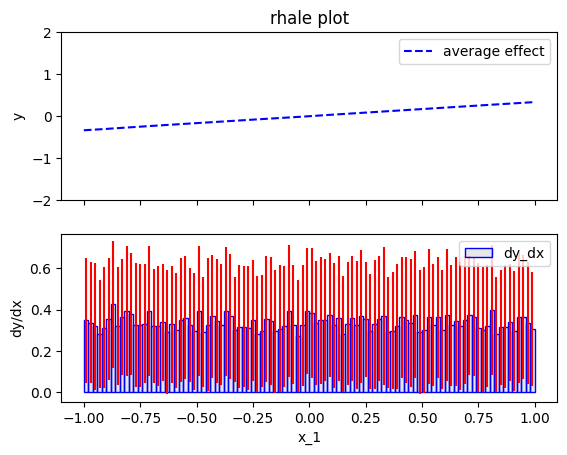

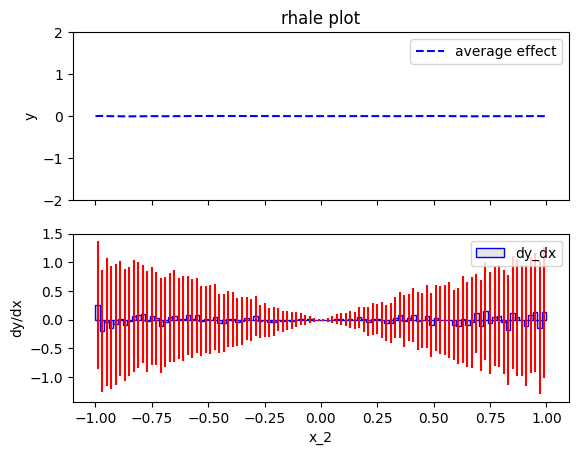

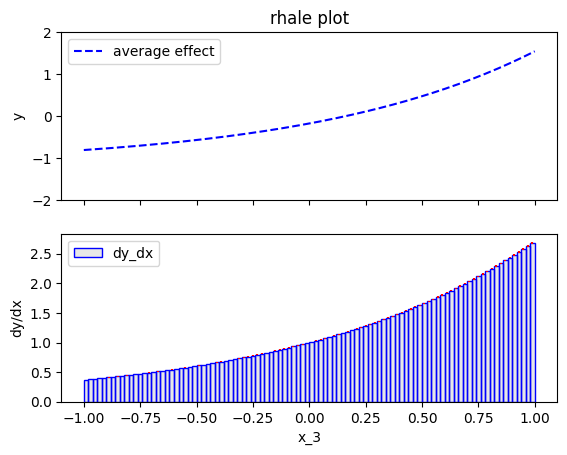

In [9]:
rhale = effector.RHALE(x, model.predict, model.jacobian, axis_limits=dataset.axis_limits)
rhale.fit(features="all", centering=True)

for feature in [0, 1, 2]:
    rhale.plot(feature=feature, centering=True, heterogeneity=True, y_limits=[-2, 2])

RHALE states that:
- $x_1$ has a zero average effect on the model output (same as PDP)
- $x_2$ has a zero average effect on the model output (different than PDP and ALE)
- $x_3$ has an effect of $e^{x_3}$ (same as PDP)


### Derivations

\begin{align}
H(x_1) &\approx
\end{align}

\begin{align}
H(x_2) &\approx
\end{align}

\begin{align}
H(x_3) &\approx
\end{align}

### Conclusions

Are the RHALE effects intuitive?